# <center> Homework2 : 频繁模式与关联规则挖掘
### <center> 吕芳蕊 3120201053
### <center> [github仓库链接] : https://github.com/feimo49/Datamine/tree/main/Homework2

## 第一章：问题描述
选择一个数据集进行频繁模式和关联规则挖掘，

要求：
- 对数据集进行处理，转换成适合进行关联规则挖掘的形式；
- 找出频繁模式；
- 导出关联规则，计算其支持度和置信度；
- 对规则进行评价，可使用Lift， 卡方和其他教材中提及的指标，至少两种；
- 对挖掘结果进行分析；
- 可视化展示。

**数据集选择**

本次作业选择了Wine Reviews数据集，共包含两个csv文件，分别为：
- winemag-data_first150k.csv, 包含10列和15万条葡萄酒评论；
- winemag-data-130k-v2.csv， 包含10列和13万条葡萄酒评论。

根据作业一中的数据预处理，我们得知其数据属性为：
- contry 国家
- description 描述
- designation 葡萄酒庄
- points 得分
- price 价格
- province 省份
- region_1 区域1
- region_2 区域2
- variety 葡萄种类
- winery 酿酒厂

## 第二章 ： 数据集处理

首先导入数据集并对数据集中的不同属性进行处理。

- 由于数据集中第一个属性未命名，是评论的序号，是唯一的，description属性是对于葡萄酒的自然语言描述，也是唯一值，所以二者在分析过程中不做考虑。
- country、province、region_1和region_2是对葡萄酒产地的位置信息，出于分析复杂性和这四个属性的数据缺失情况考虑，我们只选择其中的country进行挖掘。country属性中存在3个缺失值，所以需要通过属性的相关关系来填补缺失值，使用designation的属性来判断所属国家。
- price、points是数值属性，因此对price进行离散化处理，此外points和price属性需要加上前缀，方便区分频繁项生成结果。
- variety、winery、designation三个标称属性聚类数目过多（分别达到了632、14810、30622项），出于计算复杂度的考虑，在初步分析之后，我们单独选取variety中出现频数大于4000和winery中出现频数大于200的非空聚类进行分析。

综上，初步分析过程中选取的属性包括designation、country、price、points，在之后的找出频繁模式调用mlxtend库来实现，因此还需要将数据处理成相应的格式。

In [2]:
import matplotlib
import numpy as np
import pandas as pd

%matplotlib inline
path_15k = "../data/Wine-reviews/winemag-data_first150k.csv"
data_15k = pd.read_csv(path_15k)

#根据空值的分布，定义一个从designation到country的转换字典
designation2country = {
    "Askitikos":"Greece",    
    "Shah":"US",
    "Piedra Feliz":"Chile",
}
#处理country的空值
def country_nan_hander(data):
    for i in range(0,len(data)):
        tmp = data.iloc[i,1]
        if pd.isnull(tmp):
            designation = data.iloc[i,3]
            data.iloc[i,1] = designation2country[designation]
    return data
    
def points_discretization(value):
    return "points-"+str(int(value/5))

def price_discretization(value):
    if value < 100:
        return "price-"+str(int(value/10))
    else:
        return "price-10"
        
data_15k = pd.read_csv(path_15k)

#处理country的空值
country_nan_hander(data_15k)

#过滤属性
data_15k = data_15k.drop(['Unnamed: 0','description','province','region_1','region_2','variety','winery','designation'],axis = 1)

#离散化处理
data_15k.loc[:,'points'] = data_15k['points'].map(lambda x:points_discretization(x))
data_15k.loc[:,'price'] = data_15k['price'].map(lambda x:price_discretization(x))

#dataframe转换为列表
def deal(data):
    return data.to_list()
data_15k_arr = data_15k.apply(deal,axis=1).tolist()

#TransactionEncoder转换
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
tf = te.fit_transform(data_15k_arr)
new_df = pd.DataFrame(tf,columns=te.columns_)

## 第三章 ： 频繁模式及关联规则挖掘

### 3.1 频繁模式
调用mlxtend中的apriori函数寻找频繁模式，最小支持阈值设为0.03.

In [3]:
from mlxtend.frequent_patterns import apriori
result = apriori(new_df, min_support=0.03, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)

print(result.shape)
result[:20]

(52, 2)


,support,itemsets
9,0.526887,(points-17)
7,0.413423,(US)
12,0.303419,(price-1)
10,0.299669,(points-18)
14,0.212986,(price-2)
37,0.201034,"(points-17, price-1)"
29,0.199788,"(points-17, US)"
4,0.155556,(Italy)
8,0.153694,(points-16)
3,0.139787,(France)


### 3.2 导出关联规则
然后从频繁项集中导出关联规则，并计算其支持度和置信度。这里使用mlxtend包中的association_rules方法，支持度阈值为0.03，置信度阈值设为0.4，方法默认状态下会计算关联规则的计算支持度、置信度和提升度。

In [4]:
from mlxtend.frequent_patterns import association_rules
rules =  association_rules(result,metric ='confidence',min_threshold = 0.4)
rules = rules.drop(['leverage','conviction'],axis = 1)
print(rules.shape)
rules

(28, 7)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(price-1),(points-17),0.303419,0.526887,0.201034,0.662561,1.257503
1,(US),(points-17),0.413423,0.526887,0.199788,0.483253,0.917185
2,(price-2),(points-17),0.212986,0.526887,0.131604,0.617900,1.172737
3,(points-18),(US),0.299669,0.413423,0.128748,0.429636,1.039215
4,(price-2),(US),0.212986,0.413423,0.106460,0.499844,1.209038
5,(Italy),(points-17),0.155556,0.526887,0.093964,0.604055,1.146461
6,(points-16),(price-1),0.153694,0.303419,0.079454,0.516963,1.703795
7,(price-3),(US),0.124554,0.413423,0.076784,0.616469,1.491132
8,(points-16),(US),0.153694,0.413423,0.076048,0.494805,1.196849
9,(France),(points-17),0.139787,0.526887,0.066998,0.479287,0.909659


导出的各项关联规则如下：

In [5]:
for index, row in rules.iterrows():
    #print(row)
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%s ⇒ %s (suupport = %f, confidence = %f )"%(t1,t2,row['support'],row['confidence']))

('price-1',) ⇒ ('points-17',) (suupport = 0.201034, confidence = 0.662561 )
('US',) ⇒ ('points-17',) (suupport = 0.199788, confidence = 0.483253 )
('price-2',) ⇒ ('points-17',) (suupport = 0.131604, confidence = 0.617900 )
('points-18',) ⇒ ('US',) (suupport = 0.128748, confidence = 0.429636 )
('price-2',) ⇒ ('US',) (suupport = 0.106460, confidence = 0.499844 )
('Italy',) ⇒ ('points-17',) (suupport = 0.093964, confidence = 0.604055 )
('points-16',) ⇒ ('price-1',) (suupport = 0.079454, confidence = 0.516963 )
('price-3',) ⇒ ('US',) (suupport = 0.076784, confidence = 0.616469 )
('points-16',) ⇒ ('US',) (suupport = 0.076048, confidence = 0.494805 )
('France',) ⇒ ('points-17',) (suupport = 0.066998, confidence = 0.479287 )
('price-3',) ⇒ ('points-17',) (suupport = 0.062327, confidence = 0.500399 )
('points-17', 'price-2') ⇒ ('US',) (suupport = 0.060757, confidence = 0.461662 )
('price-2', 'US') ⇒ ('points-17',) (suupport = 0.060757, confidence = 0.570700 )
('price-1', 'US') ⇒ ('points-17',)

### 3.3 对关联规则进行评价
接下来我们对规则进行评价（使用提升度Lift和全置信度allconf）。提升度Lift已经在导出关联规则的过程中被计算出来了，如下计算全置信度。

In [6]:
def allconf(x):
    return x.support/max(x['antecedent support'],x['consequent support'])
allconf_list = []
for index, row in rules.iterrows():
    allconf_list.append(allconf(row))
rules['allconf'] = allconf_list
rules.drop(['antecedent support','consequent support'],axis=1,inplace=False)#.sort_values(by=['lift'], ascending=False)

,antecedents,consequents,support,confidence,lift,allconf
0,(price-1),(points-17),0.201034,0.662561,1.257503,0.381550
1,(US),(points-17),0.199788,0.483253,0.917185,0.379186
2,(price-2),(points-17),0.131604,0.617900,1.172737,0.249777
3,(points-18),(US),0.128748,0.429636,1.039215,0.311420
4,(price-2),(US),0.106460,0.499844,1.209038,0.257508
5,(Italy),(points-17),0.093964,0.604055,1.146461,0.178338
6,(points-16),(price-1),0.079454,0.516963,1.703795,0.261863
7,(price-3),(US),0.076784,0.616469,1.491132,0.185727
8,(points-16),(US),0.076048,0.494805,1.196849,0.183948
9,(France),(points-17),0.066998,0.479287,0.909659,0.127158


过滤掉allconf小于0.1的规则，并按照lift从大到小排序取前16项，即可得到用于分析的关联规则。

In [7]:
final_rules = rules.iloc[:]
for index, row in final_rules.iterrows():
    #print(row)
    if row['allconf'] < 0.1:
        final_rules.drop(index=index,inplace=True) 
final_rules = final_rules.sort_values(by=['lift'], ascending=False)[:16]
final_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,allconf
16,(price-10),(France),0.118121,0.139787,0.049930,0.422706,3.023936,0.357190
27,(price-5),(points-18),0.049990,0.299669,0.030405,0.608217,2.029632,0.101461
19,(price-4),(points-18),0.082840,0.299669,0.043855,0.529393,1.766594,0.146344
6,(points-16),(price-1),0.153694,0.303419,0.079454,0.516963,1.703795,0.261863
7,(price-3),(US),0.124554,0.413423,0.076784,0.616469,1.491132,0.185727
23,"(points-16, US)",(price-1),0.076048,0.303419,0.033936,0.446245,1.470723,0.111846
14,(price-10),(points-18),0.118121,0.299669,0.051898,0.439365,1.466169,0.173185
17,(price-4),(US),0.082840,0.413423,0.049692,0.599856,1.450948,0.120196
15,(price-3),(points-18),0.124554,0.299669,0.049990,0.401351,1.339316,0.166818
0,(price-1),(points-17),0.303419,0.526887,0.201034,0.662561,1.257503,0.381550


### 3.4 结果分析及可视化展示
最后生成的规则如下：

In [8]:
i = 1
for index, row in final_rules.iterrows():
    t1 = tuple(row['antecedents'])
    t2 = tuple(row['consequents'])
    print("%d : %s ⇒ %s (suupport = %f, confidence = %f )"%(i,t1,t2,row['support'],row['confidence']))
    i = i + 1

1 : ('price-10',) ⇒ ('France',) (suupport = 0.049930, confidence = 0.422706 )
2 : ('price-5',) ⇒ ('points-18',) (suupport = 0.030405, confidence = 0.608217 )
3 : ('price-4',) ⇒ ('points-18',) (suupport = 0.043855, confidence = 0.529393 )
4 : ('points-16',) ⇒ ('price-1',) (suupport = 0.079454, confidence = 0.516963 )
5 : ('price-3',) ⇒ ('US',) (suupport = 0.076784, confidence = 0.616469 )
6 : ('points-16', 'US') ⇒ ('price-1',) (suupport = 0.033936, confidence = 0.446245 )
7 : ('price-10',) ⇒ ('points-18',) (suupport = 0.051898, confidence = 0.439365 )
8 : ('price-4',) ⇒ ('US',) (suupport = 0.049692, confidence = 0.599856 )
9 : ('price-3',) ⇒ ('points-18',) (suupport = 0.049990, confidence = 0.401351 )
10 : ('price-1',) ⇒ ('points-17',) (suupport = 0.201034, confidence = 0.662561 )
11 : ('price-2',) ⇒ ('US',) (suupport = 0.106460, confidence = 0.499844 )
12 : ('points-16',) ⇒ ('US',) (suupport = 0.076048, confidence = 0.494805 )
13 : ('price-2',) ⇒ ('points-17',) (suupport = 0.131604, co

price和points的数值越大代表价格越高、分数越高。根据规则2，3，4，7，9，10，13可以看出，价格对葡萄酒的评分存在一定的影响，价格比较低（price-1和price-2，对应价格区间为10-29）的葡萄酒的评分更多地集中在16和17的评分档位（对应百分制评分的80-89）。而价格相对较高的葡萄酒（price-3到price-10，价格为30以上的）评分集中在18的评分档位（对应百分制评分的90-95），而且当价格高于price-40（price>40）档位后，评分并不会升高。
此外，从('price-4',) ⇒ ('US',) ('price-2',) ⇒ ('US',) ('price-16',) ⇒ ('US',) ('price-1', 'US')的规则可以看出，来自美国的葡萄酒的价格分布比较广泛。
从('price-10',) ⇒ ('France',),('Italy',) ⇒ ('points-17',)的规则可以看出，法国的葡萄酒的价格较高（price超过100），来自意大利的葡萄酒评分居中（points位于85-90之间）。

使用散点图可视化生成的rules规则：

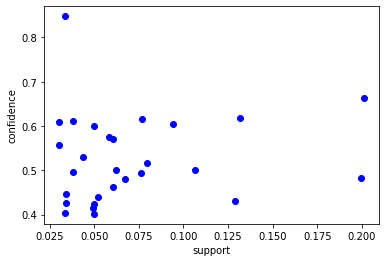

In [14]:
import  matplotlib.pyplot as plt
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],c='b')


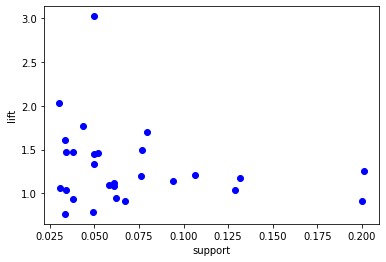

In [15]:
plt.xlabel('support')
plt.ylabel('lift')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.lift[i],c='b')

## 第四章 ： 考虑variety和winery属性的频繁模式与关联规则挖掘

### 4.1 数据处理

In [16]:
df2 = pd.read_csv(path_15k)

#处理country的空值
country_nan_hander(df2)

#过滤属性
df2 = df2.drop(['Unnamed: 0','description','province','region_1','region_2','designation'],axis = 1)

#离散化处理
df2.loc[:,'points'] = df2['points'].map(lambda x:points_discretization(x))
df2.loc[:,'price'] = df2['price'].map(lambda x:price_discretization(x))

#选取variety中出现频数大于4000的非空聚类所包括的行
variety_group = df2['variety'].value_counts()
variety_keys = []
for k in variety_group.keys():
    if variety_group[k]>4000: variety_keys.append(k)
df2_v = df2.loc[df2['variety'].isin(variety_keys)]
df2_v.drop(['winery'],axis = 1,inplace = True)

#选取winery中出现频数大于200的非空聚类所包括的行
winery_group = df2['winery'].value_counts()
winery_keys = []
for k in winery_group.keys():
    if winery_group[k]>200: winery_keys.append(k)
df2_w = df2.loc[df2['winery'].isin(winery_keys)]
df2_w.drop(['variety'],axis = 1,inplace = True)

#variety dataframe转换为列表
def deal(data):
    return data.to_list()
df2_v_arr = df2_v.apply(deal,axis=1).tolist()

#variety TransactionEncoder转换
te = TransactionEncoder()
tf = te.fit_transform(df2_v_arr)
new_df2_v = pd.DataFrame(tf,columns=te.columns_)

#winery dataframe转换为列表
def deal(data):
    return data.to_list()
df2_w_arr = df2_w.apply(deal,axis=1).tolist()

#winery TransactionEncoder转换
te = TransactionEncoder()
tf = te.fit_transform(df2_w_arr)
new_df2_w = pd.DataFrame(tf,columns=te.columns_)

### 4.2 频繁模式
variety和其它属性的频繁模式，最小支持度阈值取0.05

In [17]:
variety_result = apriori(new_df2_v, min_support=0.05, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)
variety_result

,support,itemsets
12,0.550311,(US)
14,0.493068,(points-17)
15,0.329475,(points-18)
16,0.261695,(price-1)
39,0.257547,"(points-17, US)"
18,0.208062,(price-2)
40,0.186770,"(US, points-18)"
2,0.177213,(Chardonnay)
7,0.174875,(Pinot Noir)
46,0.166041,"(points-17, price-1)"


winery和其它属性的频繁模式，最小支持度阈值取0.05

In [18]:
winery_result = apriori(new_df2_w, min_support=0.05, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)
winery_result

,support,itemsets
12,0.596892,(US)
15,0.462523,(points-17)
16,0.387569,(points-18)
19,0.272852,(price-1)
49,0.271024,"(US, points-18)"
...,...,...
26,0.051645,"(points-17, Argentina)"
71,0.051645,"(price-5, Testarossa, US)"
45,0.051645,"(Trapiche, points-17)"
44,0.051645,"(price-5, Testarossa)"


### 4.3 导出关联规则及规则评价

从频繁项集中导出关联规则，并计算其支持度和置信度，支持度阈值为0.05，置信度阈值设为0.1，方法默认状态下会计算关联规则的计算支持度、置信度和提升度,此外额外计算规则的全置信度。

In [19]:
#variety 关联规则导出
rules_v =  association_rules(variety_result,metric ='confidence',min_threshold = 0.5)
rules_v = rules_v.drop(['leverage','conviction'],axis = 1)

allconf_list = []
for index, row in rules_v.iterrows():
    allconf_list.append(allconf(row))
rules_v['allconf'] = allconf_list

print(rules_v.shape)
rules_v[:]

(26, 8)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,allconf
0,(points-17),(US),0.493068,0.550311,0.257547,0.522336,0.949164,0.468002
1,(points-18),(US),0.329475,0.550311,0.186770,0.566871,1.030091,0.339389
2,(price-1),(points-17),0.261695,0.493068,0.166041,0.634481,1.286802,0.336750
3,(price-2),(points-17),0.208062,0.493068,0.127275,0.611716,1.240632,0.258128
4,(Pinot Noir),(US),0.174875,0.550311,0.126528,0.723532,1.314769,0.229921
5,(price-2),(US),0.208062,0.550311,0.123077,0.591543,1.074923,0.223650
6,(Cabernet Sauvignon),(US),0.156630,0.550311,0.112309,0.717031,1.302955,0.204083
7,(price-3),(US),0.143562,0.550311,0.102825,0.716246,1.301529,0.186850
8,(Chardonnay),(US),0.177213,0.550311,0.099448,0.561179,1.019749,0.180712
9,(points-16),(US),0.152103,0.550311,0.091409,0.600965,1.092046,0.166103


In [21]:
#winery 关联规则导出
rules_w =  association_rules(winery_result,metric ='confidence',min_threshold = 0.5)
rules_w = rules_w.drop(['leverage','conviction'],axis = 1)

allconf_list = []
for index, row in rules_w.iterrows():
    allconf_list.append(allconf(row))
rules_w['allconf'] = allconf_list

print(rules_w.shape)
rules_w[:]

(88, 8)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,allconf
0,(points-18),(US),0.387569,0.596892,0.271024,0.699292,1.171556,0.454058
1,(points-17),(US),0.462523,0.596892,0.248172,0.536561,0.898925,0.415773
2,(price-1),(points-17),0.272852,0.462523,0.200640,0.735343,1.589853,0.433794
3,(Williams Selyem),(US),0.170932,0.596892,0.170932,1.000000,1.675345,0.286371
4,(Testarossa),(US),0.125229,0.596892,0.125229,1.000000,1.675345,0.209801
...,...,...,...,...,...,...,...,...
83,"(Trapiche, points-17)",(Argentina),0.051645,0.093693,0.051645,1.000000,10.673171,0.551220
84,"(points-17, Argentina)",(Trapiche),0.051645,0.093693,0.051645,1.000000,10.673171,0.551220
85,"(Trapiche, Argentina)",(points-17),0.093693,0.462523,0.051645,0.551220,1.191767,0.111660
86,(Trapiche),"(points-17, Argentina)",0.093693,0.051645,0.051645,0.551220,10.673171,0.551220


### 4.4 结果分析及可视化

在variety和其它属性（price、points和country）导出的关联规则中，列出提升度前20条规则。

In [22]:
rules_v.sort_values(by='lift', ascending=False)[:20]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,allconf
19,(Bordeaux-style Red Blend),(France),0.089903,0.150206,0.060694,0.675105,4.494525,0.404073
18,(price-10),(France),0.103266,0.150206,0.062261,0.602915,4.013916,0.414501
11,(points-16),(price-1),0.152103,0.261695,0.077557,0.509895,1.948432,0.296362
21,(price-4),(points-18),0.103841,0.329475,0.054943,0.529107,1.605910,0.166760
22,(price-10),(points-18),0.103266,0.329475,0.053230,0.515464,1.564502,0.161560
24,"(Pinot Noir, points-18)",(US),0.067987,0.550311,0.052080,0.766019,1.391973,0.094637
12,(price-4),(US),0.103841,0.550311,0.076663,0.738275,1.341558,0.139309
23,(Syrah),(US),0.071279,0.550311,0.052300,0.733734,1.333307,0.095037
4,(Pinot Noir),(US),0.174875,0.550311,0.126528,0.723532,1.314769,0.229921
6,(Cabernet Sauvignon),(US),0.156630,0.550311,0.112309,0.717031,1.302955,0.204083


(Bordeaux-style Red Blend)→(France) 可以看出Bordeaux-style Red Blend品种的葡萄大都种植在法国；
(Syrah)→(US)、 (Pinot Noir)→(US)、(Cabernet Sauvignon)→(US) Syrah、Pinot Noir和Cabernet Sauvignon品种的葡萄大都种植在美国。

对variety和其它属性关联规则进行可视化：

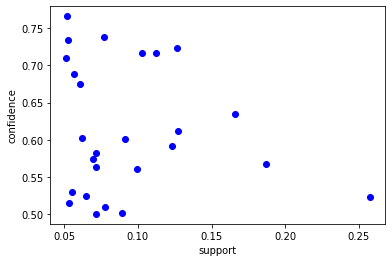

In [24]:
import  matplotlib.pyplot as plt
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules_v.shape[0]):
    plt.scatter(rules_v.support[i],rules_v.confidence[i],c='b')

在winery和其它属性（price、points和country）导出的关联规则中，列出提升度前30条规则。

In [25]:
rules_w.sort_values(by='lift', ascending=False)[:12]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,allconf
24,(Bouchard Père & Fils),(France),0.092779,0.092779,0.092779,1.000000,10.778325,1.000000
23,(France),(Bouchard Père & Fils),0.092779,0.092779,0.092779,1.000000,10.778325,1.000000
87,(Argentina),"(Trapiche, points-17)",0.093693,0.051645,0.051645,0.551220,10.673171,0.551220
84,"(points-17, Argentina)",(Trapiche),0.051645,0.093693,0.051645,1.000000,10.673171,0.551220
21,(Trapiche),(Argentina),0.093693,0.093693,0.093693,1.000000,10.673171,1.000000
83,"(Trapiche, points-17)",(Argentina),0.051645,0.093693,0.051645,1.000000,10.673171,0.551220
78,(Argentina),"(Trapiche, price-1)",0.093693,0.054388,0.054388,0.580488,10.673171,0.580488
77,(Trapiche),"(Argentina, price-1)",0.093693,0.054388,0.054388,0.580488,10.673171,0.580488
22,(Argentina),(Trapiche),0.093693,0.093693,0.093693,1.000000,10.673171,1.000000
75,"(Argentina, price-1)",(Trapiche),0.054388,0.093693,0.054388,1.000000,10.673171,0.580488


(France)→(Bouchard Père & Fils)，Bouchard Père & Fils是法国比较普遍的葡萄酒庄园;
(Trapiche)→(Argentina)和(Argentina)→(Trapiche) Trapiche是阿根廷比较普遍的葡萄酒庄园;
(Trapiche)→(Argentina, price-1) Trapiche葡萄酒庄园的葡萄酒价格较为便宜(价格区间在11-19之间).

对winery和其它属性关联规则进行可视化

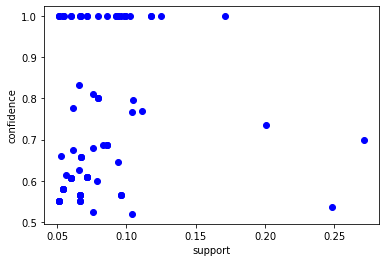

In [39]:
import  matplotlib.pyplot as plt
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules_w.shape[0]):
    plt.scatter(rules_w.support[i],rules_w.confidence[i],c='b')